# Advanced usage of modAL

This tutorial is about providing you even more knowledge about the powerful key features of the *modAL* package.

After you've already learned about the basics of active learning it's time to delve into the different possibilities *modAL* holds up for you.

In this tutorial you will:
- Learn to use different types of active learner models
- Get to know different types of sampling strategies for each introduced active learner model

## Installation

To install modAL you can use this command which will install the package directly from source:

`%pip install git+https://github.com/modAL-python/modAL.git`

(Remove `%` if you are running this command from your terminal or from a .py-file)

In [ ]:
%pip install git+https://github.com/modAL-python/modAL.git

## Committee Regression

One of the popular active learning strategies is the Query by Committee (also: Ensemble), where we keep several hypotheses (i.e. trained classifiers) about the data, and we select our queries by measuring the disagreement of the hypotheses. In modAL, this model is implemented in the `Committee` and `CommitteeRegressor` class.

In this section we will learn more about the `CommitteeRegressor` because it provides a neat way of obtaining the uncertainty about a point completely independent of the chosen type of estimation model. Ensemble regression models can be used therefore in a broad set of scenarios, because the standard deviation of the predictions at a given point can be thought of as a measure of disagreement. Hence, we get an uncertainty estimation delivered for free by training multiple models at once!

Isn't that great? Let's check it out!

Let's use the same ground truth as we had in the previous tutorial about active learning

In [123]:
import numpy as np

np.random.seed(42)

# training data
x_training = np.random.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
ground_truth = lambda x: np.sin(x) + np.random.normal(scale=0.3, size=x.shape)
y_training = ground_truth(x_training)

# test data
x_test = np.linspace(0, 20, 1000)
y_test = ground_truth(x_test)

Let's see how our dataset looks like

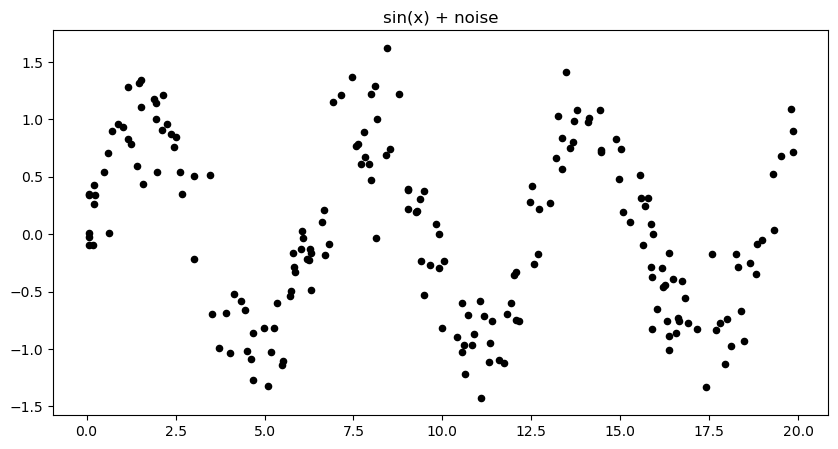

In [115]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.scatter(x_training, y_training, c='k', s=20)
plt.title('sin(x) + noise')
plt.show()

If you have several regressors, measuring disagreement can be done by calculating the standard deviation of the predictions for each point. In the simplest setting, this is implemented in the function `modAL.disagreement.max_std_sampling`.

This measure is default for `CommitteeRegressors`, so we don’t need to specify this upon initialization. But we are going to do it anyways ;)

Let's define the active learner and train it with some random initial samples

In [116]:
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

# from sklearn.tree import DecisionTreeRegressor as model

n_initial = 15  # initial amount of random samples
n_regressor = 3 # number of regressors in the ensemble; n_initial samples are divided evenly among the regressors

# get initial training data - random samples
initial_idx = np.random.choice(range(len(x_training)), size=n_initial, replace=False)  # draw random initial indices
initial_idx = initial_idx.reshape(-1, n_regressor)  # reshape to list of lists

# define a kernel for the Gaussian process regressor
# RBF will approximate the non-linearities and WhiteKernel will add noise to the model
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))

# first we have to initialize the single active learners
# in this case each learner will be trained on only one sample
learner_list = []
for idx_learner in range(initial_idx.shape[1]):
    learner_list.append(
        ActiveLearner(
            estimator=GPR(kernel),
            X_training=x_training[initial_idx[:, idx_learner]].reshape(-1, 1), y_training=y_training[initial_idx[:, idx_learner]].reshape(-1, 1),
        )
    )

# initializing the Committee
committee = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

print(f'Number of learners in the committee: {len(committee)}')

Number of learners in the committee: 3


/home/daniel/miniconda3/envs/oed/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Let's check the initial prediction of our ensemble

In [ ]:
from sklearn.metrics import mean_squared_error

# let's define a plotting method that we can reuse throughout the experiment
def plotting_method(committee: CommitteeRegressor, x, x_true=None, y_true=None, x_new=None, mse=None):
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    for learner_idx, learner in enumerate(committee):
        plt.plot(x, learner.predict(x.reshape(-1, 1)), linewidth=2)
    
    if x_true is not None and y_true is not None:
        plt.scatter(x_true, y_true, c='grey')
    plt.title('Predictions of the single regressors')

    plt.subplot(1, 2, 2)
    pred, std = committee.predict(x.reshape(-1, 1), return_std=True)
    pred = pred.reshape(-1, )
    std = std.reshape(-1, )
    plt.plot(x, pred, c='r', linewidth=2)
    plt.fill_between(x, pred - std, pred + std, alpha=0.2)
    if x_true is not None and y_true is not None:
        plt.scatter(x_true, y_true, c='grey')
    if x_new is not None:
    # make a vertical line to indicate the new training sample
        if isinstance(x_new, int):
            x_new = [x_new]
        for x in x_new:
            plt.axvline(x=x, c='r', linestyle='--', label='New query')
    if mse is not None:
        plt.title(f'Prediction of the ensemble\nMSE of the ensemble: {mse:.3f}')
    else:
        plt.title('Prediction of the ensemble')
    plt.show()

mse = mean_squared_error(y_test, committee.predict(x_test.reshape(-1, 1)))
plotting_method(committee, x_test, x_true=x_training, y_true=y_training, mse=mse)  # plot the initial predictions

Now we are ready to do active learning!

In [ ]:
n_queries = 1

query_idx, query_instances = committee.query(x_training, n_instances=n_queries)  # get the query points from the regressor which are expected to be the most informative
committee.teach(x_training[query_idx].reshape(-1, 1), y_training[query_idx].reshape(-1, 1))  # fit the model with the query points

mse = mean_squared_error(y_test, committee.predict(x_test.reshape(-1, 1)))
plotting_method(committee, x_test, x_true=x_training, y_true=y_training, x_new=query_instances, mse=mse)  # plot the predictions after the first query

Does it look already any better?

What happened from the initial plot to the second one?

Let's iterate a few more times and check the result after each iteration!

In [ ]:
iterations = 10

for _ in range(iterations):
    query_idx, query_instance = committee.query(x_training, n_instances=n_queries)  # get the query points from the regressor which are expected to be the most informative
    committee.teach(x_training[query_idx].reshape(-1, 1), y_training[query_idx].reshape(-1, 1))  # fit the model with the query points
    
    # compute the mean squared error
    mse = mean_squared_error(y_test, committee.predict(x_test.reshape(-1, 1)))

    plotting_method(committee, x_test, x_true=x_training, y_true=y_training, x_new=x_training[query_idx], mse=mse)

What's the difference between a single active learner (as you have seen its behavior in the last tutorial) and the `CommitteeRegressor` in terms of their expected behavior?

As a practice and to get a feeling for the `CommitteeRegressor` try to tweak following parameters and see what happens:
- increase the noise of the ground truth
- increase the number of initial samples
- increase the number of regressors in the ensemble
- increase the number of queries per iteration

Compare also with the `ActiveLearner` model and random sampling from the last tutorial.

In which scenarios is the `CommitteeRegressor` most useful?

## Bayesian Optimization

In Bayesian optimization, instead of picking queries by maximizing the uncertainty of predictions, function values are evaluated at points where the promise of finding a better value is large. In *modAL*, these algorithms are implemented with the `BayesianOptimizer` class, which is a sibling of `ActiveLearner`. Initializing a `BayesianOptimizer` is syntactically identical to the initialization of `ActiveLearner`, although there is an important difference.

In Bayesian optimization, a so-called acquisition funciton is used instead of the uncertainty based utility measures of active learning. In *modAL*, Bayesian optimization algorithms are implemented in the `modAL.models.BayesianOptimizer` class. Currently, there are three available acquisition functions in the `modAL.acquisition` module: expected improvement `max_EI`, probability of improvement `max_PI` and upper confidence bounds `max_UCB`. You can find more information about them and the mathematical reasoning behind them [here](https://modal-python.readthedocs.io/en/latest/content/query_strategies/Acquisition-functions.html).

Let's initialize the `BayesianOptimizer` in the first step. Here we will start with the acquisition function for maximizing the expected improvement `max_EI`.

In [124]:
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI, max_PI, max_UCB

n_initial = 5  # initial number of points
initial_idx = np.random.choice(range(len(x_training)), size=n_initial, replace=False)  # draw random initial indices

# we will use the same kernel as before
optimizer = BayesianOptimizer(
    estimator=GPR(kernel),
    query_strategy=max_EI,
    X_training=x_training[initial_idx].reshape(-1, 1), y_training=y_training[initial_idx].reshape(-1, 1),
)

Let's write a re-usable plotting_method for the `BayesianOptimizer` and check how it performs.

We will simply take the plotting method from the `ActiveLearner` tutorial.

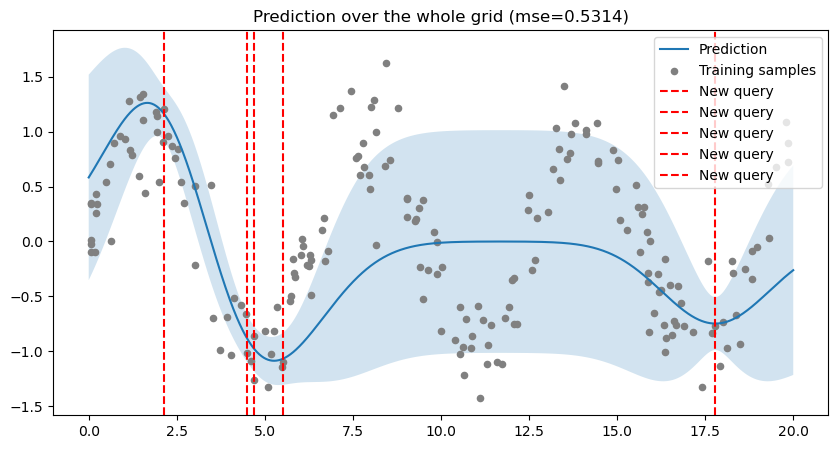

In [125]:
from sklearn.metrics import mean_squared_error

y_pred, y_std = optimizer.predict(x_test.reshape(-1, 1), return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

# compute the mean squared error
mse = mean_squared_error(y_test, y_pred)

# plotting method which we can reuse later
def plotting_method(x1, y1, y1_std, x_true=None, y_true=None, mse=None, x_new=None):
    plt.figure(figsize=(10, 5))
    plt.plot(x1, y1, label='Prediction')
    plt.fill_between(x1, y1 - y1_std, y1 + y1_std, alpha=0.2)
    if x_true is not None and y_true is not None:
        plt.scatter(x_true, y_true, c='grey', s=20, label='Training samples')
    if x_new is not None:
        # make a vertical line to indicate the new training sample
        if isinstance(x_new, (int, float)):
            x_new = [x_new]
        for x in x_new:
            plt.axvline(x=x, c='r', linestyle='--', label='New query')
    if mse is not None:
        plt.title(f'Prediction over the whole grid (mse={np.round(mse, 4)})')
    else:
        plt.title('Prediction')
    plt.legend()
    plt.show()

plotting_method(x_test, y_pred, y_std, x_true=x_training, y_true=y_training, mse=mse, x_new=x_training[initial_idx])

How does it look? Is there anything familiar in this plot?

Let's train on!

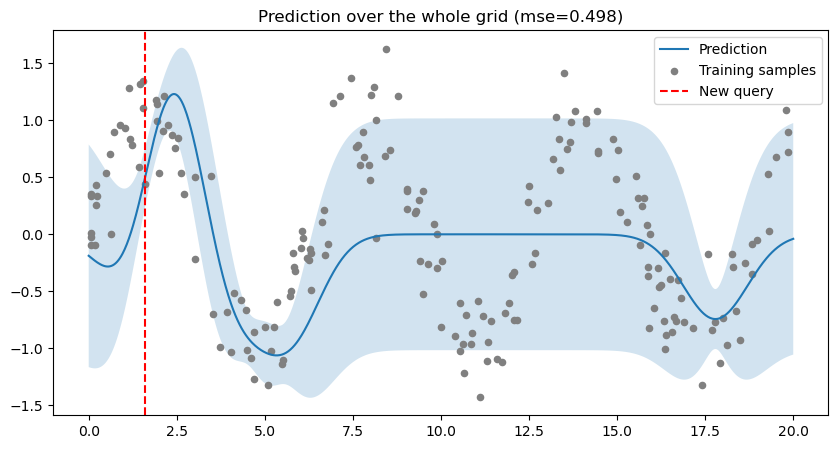

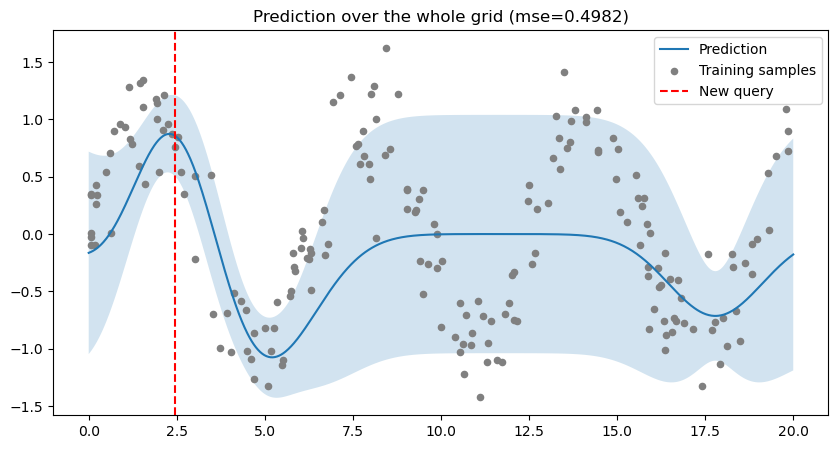

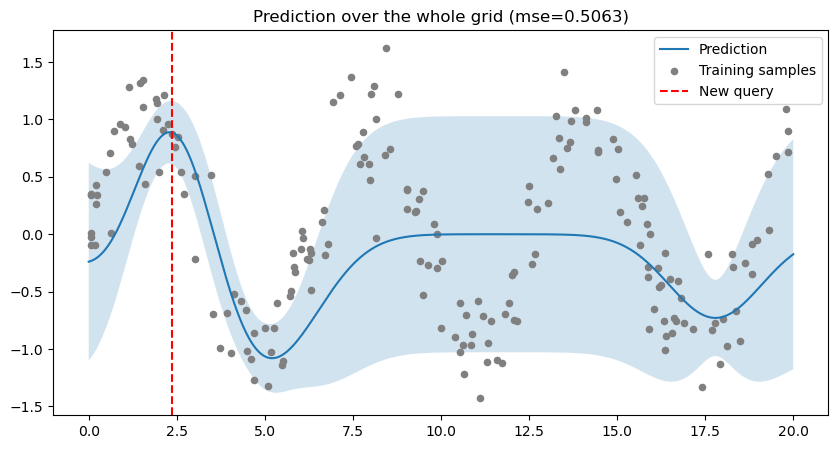

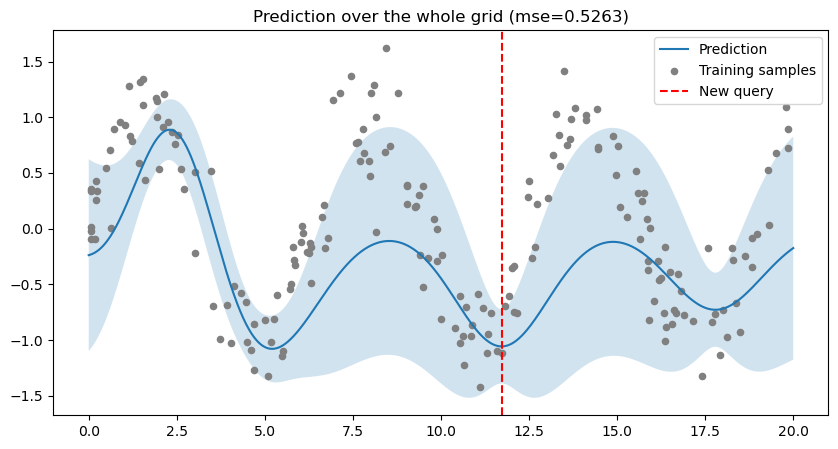

/home/daniel/miniconda3/envs/oed/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/daniel/miniconda3/envs/oed/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


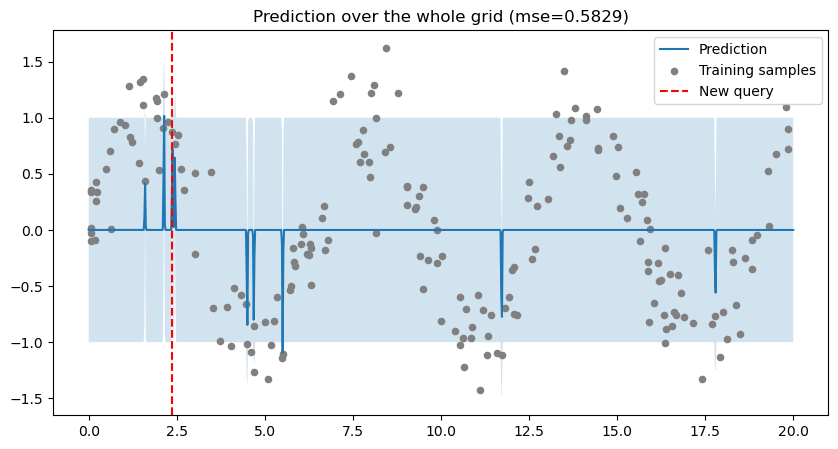

/home/daniel/miniconda3/envs/oed/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


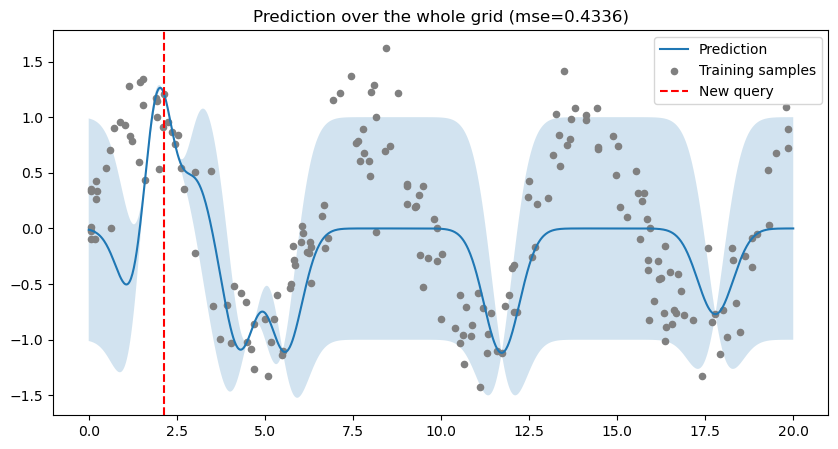

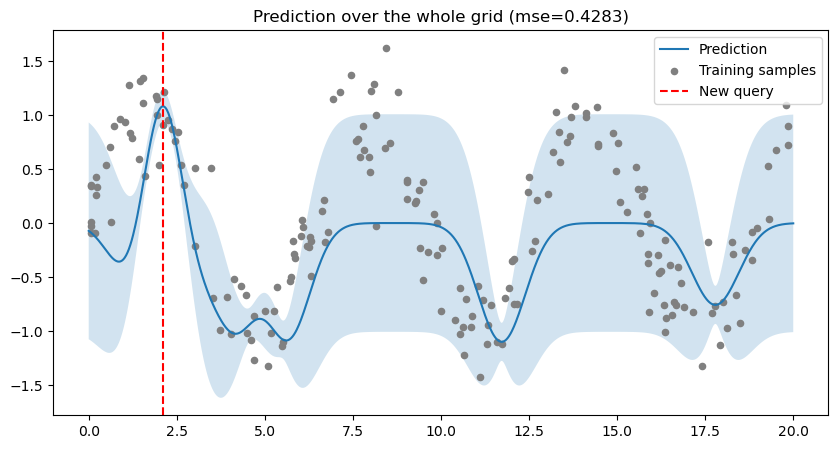

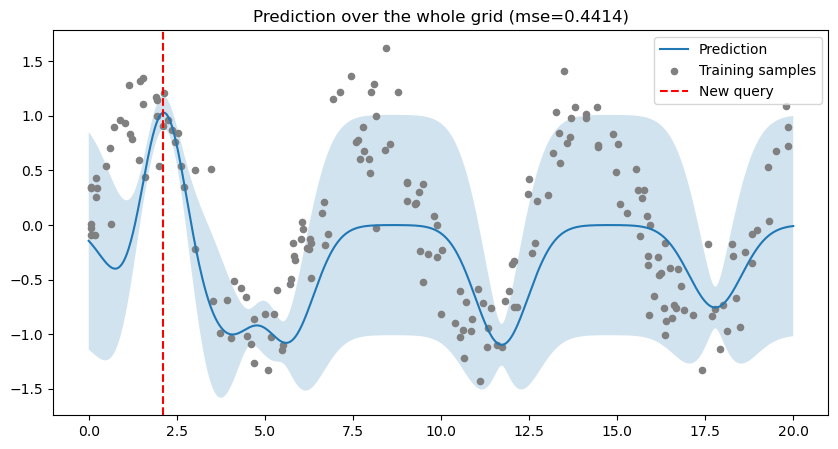

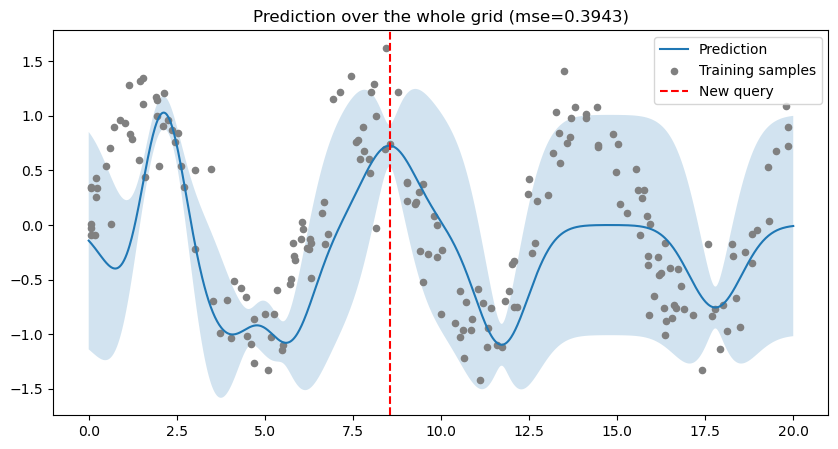

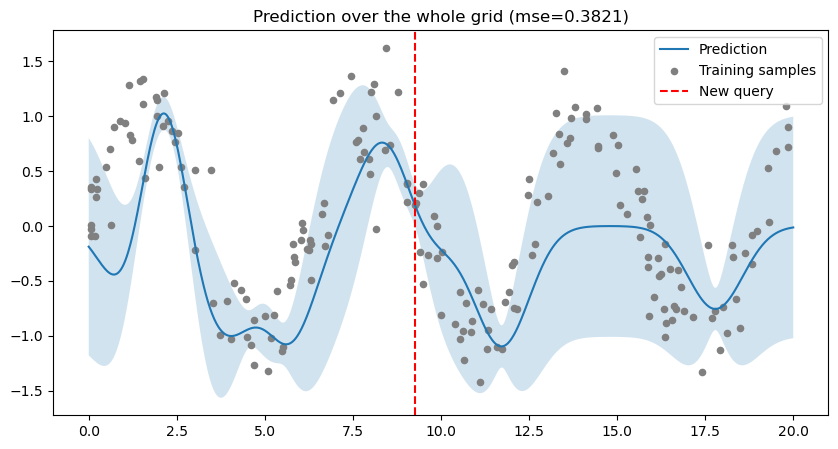

In [126]:
iterations = 10

for _ in range(iterations):
    query_idx, query_instance = optimizer.query(x_training, n_instances=n_queries)  # get the query points from the regressor which are expected to be the most informative
    optimizer.teach(x_training[query_idx].reshape(-1, 1), y_training[query_idx].reshape(-1, 1))  # fit the model with the query points
    
    # get the predicted response and the standard deviation
    y_pred, y_std = optimizer.predict(x_test.reshape(-1, 1), return_std=True)
    # y_pred, y_std = y_pred.ravel(), y_std.ravel()

    # compute the mean squared error
    mse = mean_squared_error(y_test, y_pred)

    plotting_method(x_test, y_pred, y_std, x_true=x_training, y_true=y_training, mse=mse, x_new=x_training[query_idx])

What is the acquisition function doing exactly?

Try the other ones as well, play with the hyperparameters and compare the new behavior with the seen ones.

When might the `BayesianOptimizer` be most useful? Where are its downsides?

## Congratulations!

You've finished the advanced tutorial for active learning and the *modAL* package.

As you have maybe noticed, active learning needs some/a lot of informed hyperparameter tweaking and twisting. Further, there's not the one solution for every case. Active learning should be used where it is expected to bring benefits and not just blindly being adapted in every imaginable scenario.

You've seen now some of the most popular and very distinct ways for optimizing experimental design.

## Optional: Increasing ground truth complexity

You have seen now most of the important features of the *modAL* package. Congratulations!

Implement now your own ground truth. Make it more complex, add factors, levels and noise as you've seen it in the tutorial about synthetic experimentation and benchmark the introduced active learning algorithms against some baselines like random sampling.

Have fun!

In [127]:
# add your code here